In [1]:
import warnings
import pandas as pd
from pycaret.classification import *

seed = 1
warnings.filterwarnings("ignore")

In [2]:
df_training = pd.read_parquet("data/training_03.parquet")

In [3]:
df_training = df_training.sample(n=500_000, random_state=seed)
df_training.label.mean()

0.03151

In [5]:
numeric_features = ['avg_n_transactions_weekly_customer', 'avg_spending_weekly',
       'highest_price_paid', 'lowest_price_paid',
       'sum_spending_last_week', 'n_transactions_last_week_customer',
       'current_price', 'avg_n_transactions_weekly_product',
       'avg_returns_weekly', 'sum_returns_last_week',
       'n_transactions_last_week_product', 'sum_returns_last_week_general',
       'moving_avg_returns_lm', 'sum_transactions_last_week_general',
       'moving_avg_transactions_lm', 'ratings'
]

categorical_features = [
    'pays_above_avg', 'costs_above_avg', 'within_budget'
]

In [7]:
setup_params = {
    "target": "label",
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "silent": True,
    "fold" : 3,
    "session_id": seed,
    "preprocess": False,
    "remove_perfect_collinearity": False,
    "n_jobs": -2,
    "data": df_training
}

prep = setup(**setup_params)

,Description,Value
0,session_id,1
1,Target,label
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(500000, 19)"
5,Missing Values,0
6,Numeric Features,15
7,Categorical Features,3
8,Transformed Train Set,"(349999, 18)"
9,Transformed Test Set,"(150001, 18)"


In [8]:
include = ["catboost","gbc", "nb"]

best_models = compare_models(
    sort="AUC",
    include=include, 
    n_select=len(include)
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9681,0.7355,0.0095,0.4445,0.0186,0.0173,0.0614,41.4067
gbc,Gradient Boosting Classifier,0.9682,0.7176,0.0000,0.0000,0.0000,-0.0001,-0.0010,21.5233
nb,Naive Bayes,0.7518,0.6988,0.4937,0.0633,0.1123,0.0593,0.1032,1.2800


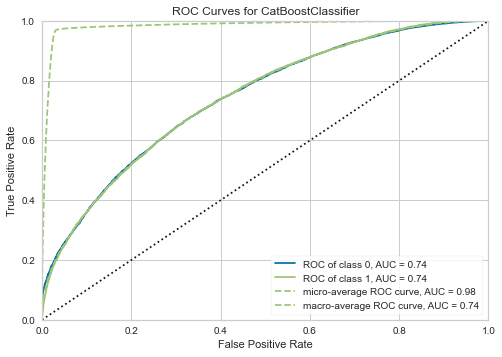

In [9]:
plot_model(estimator=best_models[0], plot="auc")

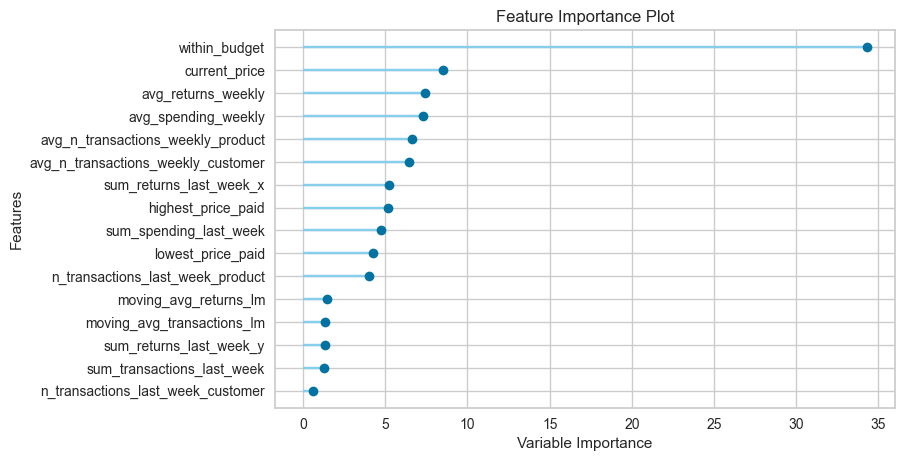

In [17]:
plot_model(estimator=best_models[0], plot="feature_all")

In [ ]:
save_model(model=best_models[0], model_name="models/catboost")

In [3]:
stacked = stack_models(best_models, optimize="auc")

In [ ]:
plot_model(estimator=stacked, plot="auc")

In [ ]:
plot_model(estimator=stacked, plot="feature_all")

In [ ]:
save_model(model=stacked, model_name="models/stacked")

In [2]:
df_training_resampled = pd.read_parquet("data/training_03_resampled.parquet").sample(n=500_000, random_state=seed)
df_test = pd.read_parquet("data/test_03.parquet").sample(n=100_000, random_state=seed)

In [3]:
len(df_training_resampled), len(df_test)

(500000, 100000)

In [6]:
setup_params = {
    "target": "label",
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "silent": True,
    "fold" : 3,
    "session_id": seed,
    "preprocess": False,
    "remove_perfect_collinearity": False,
    "n_jobs": -2,
    "test_data": df_test,
    "data": df_training_resampled
}

prep = setup(**setup_params)

,Description,Value
0,session_id,1
1,Target,label
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(500000, 20)"
5,Missing Values,0
6,Numeric Features,16
7,Categorical Features,3
8,Transformed Train Set,"(500000, 19)"
9,Transformed Test Set,"(100000, 19)"


In [7]:
include = ["catboost","gbc", "nb"]

best_models_resampled = compare_models(
    sort="AUC",
    include=include, 
    n_select=len(include)
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9139,0.7935,0.0945,0.6895,0.1662,0.1475,0.2338,47.6533
gbc,Gradient Boosting Classifier,0.9100,0.7460,0.0150,0.7041,0.0293,0.0256,0.0937,52.9067
nb,Naive Bayes,0.6460,0.7114,0.6595,0.1563,0.2528,0.1242,0.1798,1.6967


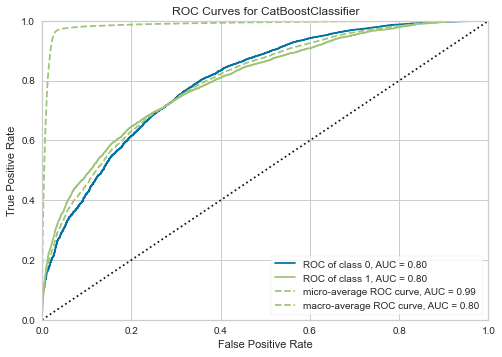

In [8]:
plot_model(estimator=best_models_resampled[0], plot="auc")

In [9]:
df_test.label.mean()

0.03232

In [10]:
for name, model in zip(include, best_models_resampled):
    print(name,
        predict_model(
            estimator=model, 
            data=df_test[df_test.columns[1:]], 
            verbose=False, 
            raw_score=True
            )["Score_1"].mean())

catboost 0.081364145
gbc 0.08606337900000001
nb 0.40262255099999994


In [ ]:
save_model(model=best_models_resampled[0], model_name="models/catboost_resampled")